# Importing libraries 

In [36]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz
from sklearn.metrics.pairwise import cosine_similarity
from diagrams import Diagram, Cluster
from diagrams.onprem.workflow import Airflow
from diagrams.onprem.database import PostgreSQL
from diagrams.onprem.analytics import Spark
from diagrams.aws.storage import S3
from diagrams.generic.compute import Rack
from diagrams.generic.database import SQL
from IPython.display import Image
!pip install diagrams

# 1) DATA PREPROCESSING - CLEAN AND PROCESS TEXT DATA 

In [32]:
# NLTK packages 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = r'C:\Users\Pranav\Downloads\Innovius_case_study_data.xlsx'
df = pd.read_excel(file_path)

# Preprocessing function
def preprocess_text(text):
    if pd.isnull(text):  
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Joining tokens 
    return ' '.join(tokens)

# Preprocess description 
if 'Description' in df.columns:
    df['Cleaned_Description'] = df['Description'].apply(preprocess_text)
elif 'Sourcescrub Description' in df.columns:
    df['Cleaned_Description'] = df['Sourcescrub Description'].apply(preprocess_text)
else:
    raise ValueError("No valid description column found for preprocessing.")

# Saving the cleaned data to below path 
output_path = r'C:\Users\Pranav\Downloads\processed_innovius_data.xlsx'
df.to_excel(output_path, index=False)

# Display the first 20 rows in the notebook
df.head(20) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pranav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pranav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pranav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Name,Website,Organization Id,Top Level Category,Secondary Category,Employee Count,Description,Sourcscrub Description,Description.1,Cleaned_Description
0,ClosingLock,closinglock.com,223865172,NaN,NaN,21,Closinglock is a company that provides wire tr...,NaN,Real Estate Wire Fraud Prevention Solution,closinglock company provides wire transfer sec...
1,"Daloopa, Inc.",daloopa.com,284044302,IT Management,Data Extraction,226,Discover how the power of over 100 AI algorith...,"Daloopa, Inc. is the only AI solution for inve...",AI-driven enterprise data that can be trusted,discover power ai algorithm automate investmen...
2,"Daloopa, Inc.",daloopa.com,284044302,IT Management,Data Extraction,226,Discover how the power of over 100 AI algorith...,"Daloopa, Inc. is the only AI solution for inve...",AI-driven enterprise data that can be trusted,discover power ai algorithm automate investmen...
3,UpSmith,upsmith.com,283999461,NaN,NaN,11,Transforming the future of work.,"UpSmith, Inc. is a provider of a skilled labor...",Significantly enhancing lives by giving people...,transforming future work
4,Equal Ventures,equal.vc,160422940,NaN,NaN,5,Equal Ventures is a venture capital firm that ...,NaN,NaN,equal venture venture capital firm focus bridg...
5,Fullpath,fullpath.com,288156669,Vertical Industry,Automotive,164,AutoLeadStar is automotive's first and leading...,"AutoLeadStar, Inc. doing business as Fullpath ...",Developed a retail engagement platform for aut...,autoleadstar automotives first leading custome...
6,Sadie Blue Software,sadiebluesoftware.com,224638688,NaN,NaN,5,Sadie Blue Software is the maker of Agility Bl...,NaN,"All your work, under control",sadie blue software maker agility blue webbase...
7,QuikData,quikdata.com,289080423,NaN,NaN,7,QuikData | Simply Powerful eDiscovery: Easy eD...,NaN,NaN,quikdata simply powerful ediscovery easy edisc...
8,StructureFlow,structureflow.co,223425789,NaN,NaN,28,StructureFlow is a visual modeling platform fo...,NaN,NaN,structureflow visual modeling platform profess...
9,DigitalOwl INST,digitalowl.com,225170600,NaN,NaN,74,DigitalOwl is an AI-powered medical record sum...,"DigitalOwl, Inc. offers an innovative NLP solu...",Machine Learning to evaluate claims and assess...,digitalowl aipowered medical record summarizat...


In [33]:
print(df.columns)

Index(['Name', 'Website', 'Organization Id', 'Top Level Category',
       'Secondary Category', 'Employee Count', 'Description',
       'Sourcscrub Description', 'Description.1', 'Cleaned_Description'],
      dtype='object')


# 2) Feature Extraction - TF-DF

# sample 1000 - rows (Processed only 1000 rows as processing entire data of 55k+ rows was consuming a lot of time)

In [30]:
# Load the cleaned dataset
file_path = r'C:\Users\Pranav\Downloads\processed_innovius_data.xlsx'
df_cleaned = pd.read_excel(file_path)

# Reducing corpus size (1000 rows)
df_cleaned = df_cleaned.sample(1000, random_state=42)  # Sample 1000 rows for testing

# Extracting the 'Cleaned_Description' column
corpus = df_cleaned['Cleaned_Description'].fillna("").tolist()

# Initialize TF-IDF Vectorizer with optimized parameters
vectorizer = TfidfVectorizer(
    max_features=500,        
    ngram_range=(1, 2),       
    stop_words='english'      
)

# Fit and transform the corpus
tfidf_matrix = vectorizer.fit_transform(corpus)

# Save the TF-IDF matrix as a sparse file (more memory-efficient)
output_sparse_path = r'C:\Users\Pranav\Downloads\tfidf_features_sparse.npz'
save_npz(output_sparse_path, tfidf_matrix)

# Save the TF-IDF feature names for reference
feature_names_path = r'C:\Users\Pranav\Downloads\tfidf_feature_names.txt'
with open(feature_names_path, 'w') as f:
    for feature in vectorizer.get_feature_names_out():
        f.write(feature + '\n')

# Convert the sparse matrix to a DataFrame for display
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Location where it will be saved 
print(f"TF-IDF feature extraction completed. Sparse matrix saved at: {output_sparse_path}")
print(f"TF-IDF feature names saved at: {feature_names_path}")

tfidf_df.head(20)

TF-IDF feature extraction completed. Sparse matrix saved at: C:\Users\Pranav\Downloads\tfidf_features_sparse.npz
TF-IDF feature names saved at: C:\Users\Pranav\Downloads\tfidf_feature_names.txt


,access,account,accounting,activity,ad,administration,advanced,advertising,affordable,agency,...,webbased,website,wide,work,workflow,workforce,world,worldwide,year,year experience
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.231794,0.273738
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.202031,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
6,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
8,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.217574,0.323927,0.0,0.0,0.0,0.0,0.000000,0.000000
9,0.214997,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


# 3) Similarity score calculation

In [8]:
# Load the TF-IDF sparse matrix
tfidf_sparse_path = r'C:\Users\Pranav\Downloads\tfidf_features_sparse.npz'
tfidf_matrix = load_npz(tfidf_sparse_path)

# number of top similar companies to retrieve
top_n = 10

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

# Extract top-N similar companies for each company
top_n_results = []
for i in range(similarity_matrix.shape[0]):
    
    scores = similarity_matrix[i]
    
    top_indices = scores.argsort()[-(top_n + 1):-1][::-1]
    top_scores = scores[top_indices]
    
    result = {"Company_ID": i}
    for rank, (idx, score) in enumerate(zip(top_indices, top_scores), start=1):
        result[f"Top_{rank}_Company_ID"] = idx
        result[f"Top_{rank}_Similarity_Score"] = score
    top_n_results.append(result)

# Converting results to a DataFrame
top_n_df = pd.DataFrame(top_n_results)

print(f"Displaying the Top-{top_n} similarity scores below:")
display(top_n_df.head(20))  # Use display() for proper rendering in Jupyter Notebook

# Save the top-N similarity scores to an Excel file
output_path = r'C:\Users\Pranav\Downloads\top_n_similarity_scores.xlsx'
top_n_df.to_excel(output_path, index=False)

print(f"Top-{top_n} similarity scores saved at:", output_path)


Displaying the Top-10 similarity scores below:


,Company_ID,Top_1_Company_ID,Top_1_Similarity_Score,Top_2_Company_ID,Top_2_Similarity_Score,Top_3_Company_ID,Top_3_Similarity_Score,Top_4_Company_ID,Top_4_Similarity_Score,Top_5_Company_ID,...,Top_6_Company_ID,Top_6_Similarity_Score,Top_7_Company_ID,Top_7_Similarity_Score,Top_8_Company_ID,Top_8_Similarity_Score,Top_9_Company_ID,Top_9_Similarity_Score,Top_10_Company_ID,Top_10_Similarity_Score
0,0,634,0.424178,927,0.397429,55,0.366424,231,0.351275,694,...,325,0.341996,954,0.336674,601,0.335624,917,0.325126,27,0.322833
1,1,483,0.561828,117,0.481914,795,0.463770,826,0.440890,785,...,312,0.334266,710,0.302429,47,0.291318,229,0.281347,829,0.273444
2,2,93,0.296984,107,0.265746,111,0.244715,237,0.215841,897,...,788,0.211960,951,0.208019,341,0.207354,17,0.205066,750,0.204569
3,3,821,0.427173,457,0.299522,708,0.273153,936,0.272511,623,...,858,0.249833,884,0.225768,246,0.218206,127,0.217082,351,0.213161
4,4,720,0.476524,696,0.438104,725,0.334810,454,0.296884,938,...,697,0.245572,7,0.244863,351,0.230058,171,0.227125,317,0.224503
5,5,199,0.400422,151,0.324442,751,0.301173,55,0.292966,458,...,135,0.267341,952,0.266377,549,0.256248,207,0.248072,622,0.247154
6,6,687,0.265162,427,0.253414,630,0.241674,800,0.241563,174,...,590,0.222352,852,0.220397,515,0.219392,285,0.219219,858,0.219094
7,7,194,0.352925,37,0.345176,71,0.291147,686,0.283368,364,...,451,0.278905,549,0.276034,884,0.269031,317,0.251750,240,0.248441
8,8,566,0.406060,770,0.386354,636,0.354462,855,0.349840,268,...,745,0.284053,677,0.278580,635,0.253150,560,0.240659,110,0.232828
9,9,600,0.447276,640,0.433340,295,0.393400,439,0.388584,59,...,443,0.383073,917,0.353072,394,0.334119,694,0.317538,227,0.313185


Top-10 similarity scores saved at: C:\Users\Pranav\Downloads\top_n_similarity_scores.xlsx


# 4) Data Engineering and scalability -  Data Pipeline Workflow 

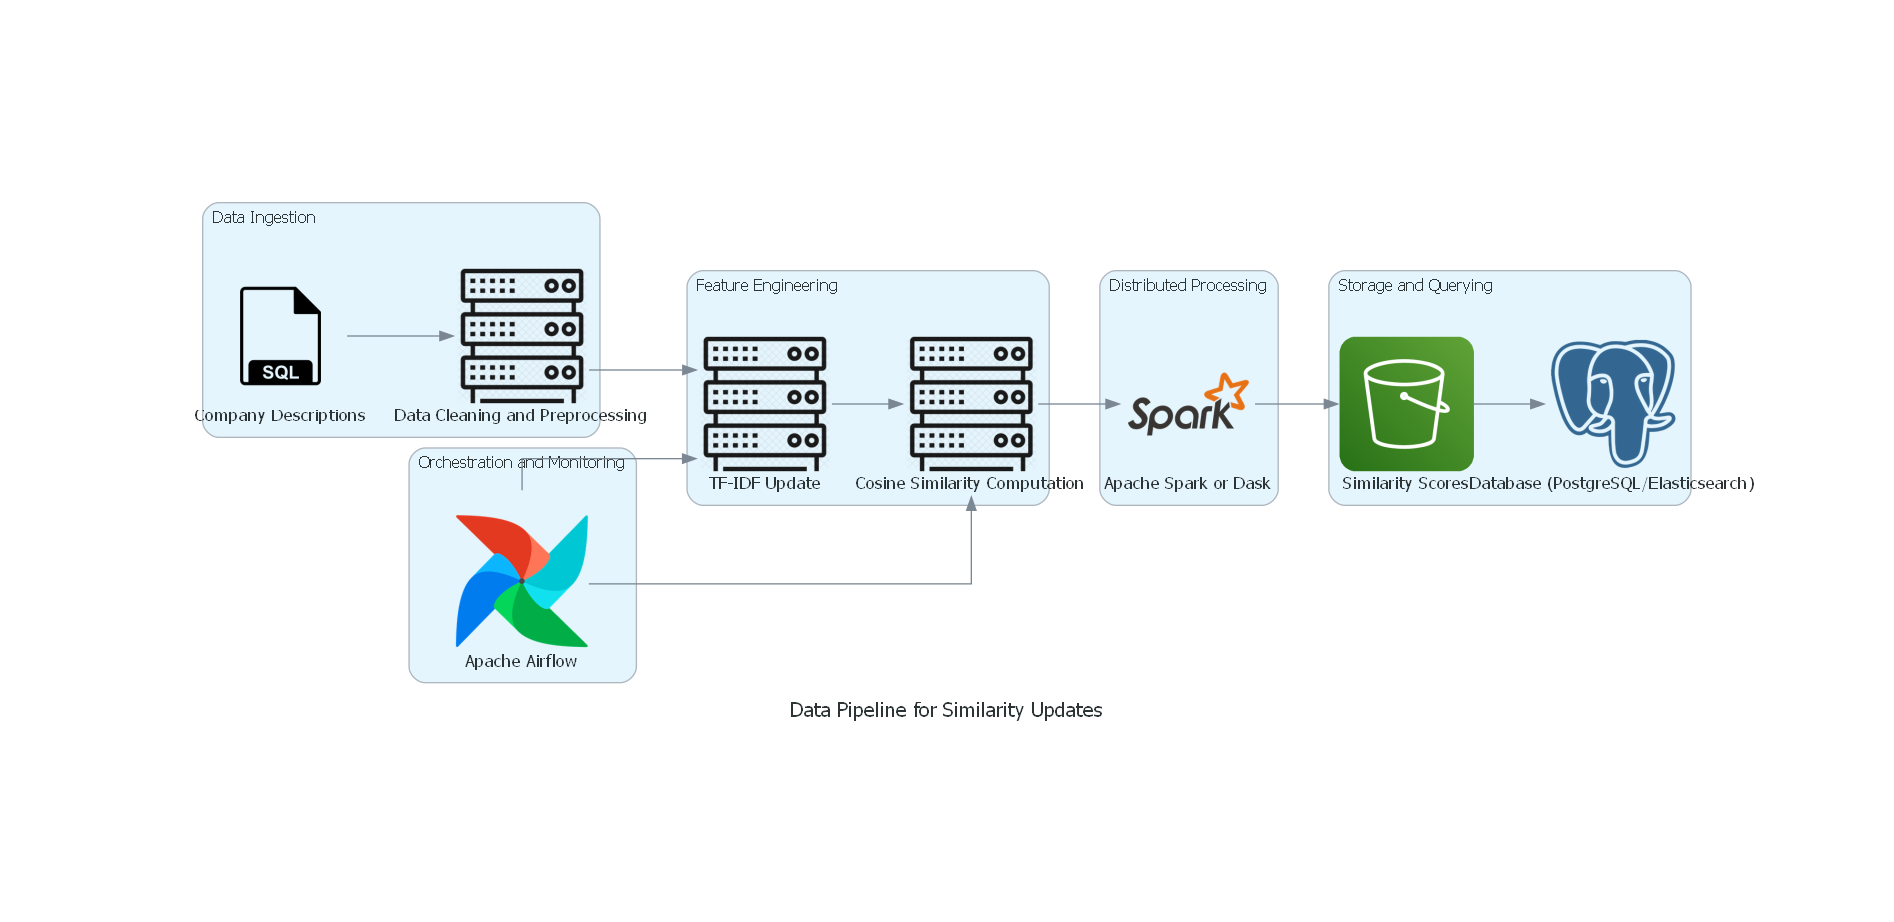

In [15]:
output_file = "data_pipeline_for_similarity_updates"

with Diagram("Data Pipeline for Similarity Updates", show=False, filename=output_file):
    # Data Ingestion 
    with Cluster("Data Ingestion"):
        input_data = SQL("Company Descriptions")
        preprocessing = Rack("Data Cleaning and Preprocessing")

    # Feature Engineering 
    with Cluster("Feature Engineering"):
        tfidf_update = Rack("TF-IDF Update")
        similarity_calc = Rack("Cosine Similarity Computation")

    # Distributed Processing 
    with Cluster("Distributed Processing"):
        spark_processing = Spark("Apache Spark or Dask")

    # Storage and Querying
    with Cluster("Storage and Querying"):
        similarity_scores = S3("Similarity Scores")
        query_db = PostgreSQL("Database (PostgreSQL/Elasticsearch)")

    # Orchestration and Monitoring 
    with Cluster("Orchestration and Monitoring"):
        workflow_manager = Airflow("Apache Airflow")

    # Connecting Components
    input_data >> preprocessing >> tfidf_update >> similarity_calc >> spark_processing
    spark_processing >> similarity_scores >> query_db
    workflow_manager >> [tfidf_update, similarity_calc]

Image(filename=f"{output_file}.png")
